# Power spectrum plots from DESI Y1 mocks

In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt

sys.path.append('../bin')
from utils import load_poles, load_poles_list
from desi_file_manager import DESIFileName

# plotting
plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plots_dir = '../../plots/'

### Global parameters

In [9]:
# tracer
tracer = 'ELG'
region = 'SGC'
zrange = (1.1, 1.6)

# mocks/version
version = 'v3'
imocks = range(25)

# multipoles
ells = (0, 2, 4)

# cut
rpcut = 0.
thetacut = 0.05

fn = DESIFileName()
fn.set_default_config(version=version, tracer=tracer, region=region)
fn.update(zrange=zrange)

## Plots

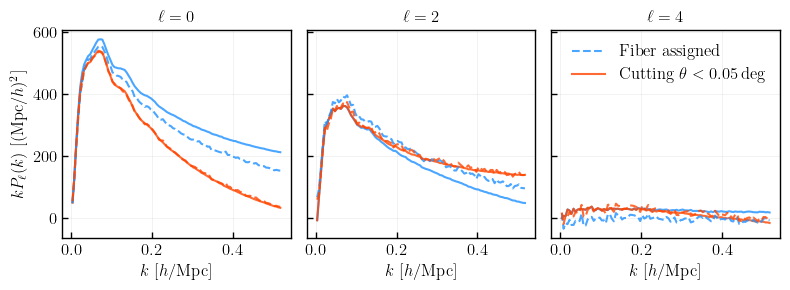

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharey=True)

for ls, completeness in zip(['-', '--'], [True, False]):
    fn.set_default_config(completeness=completeness)
    poles = load_poles_list([fn.get_path(realization=imock, rpcut=0, thetacut=0) for imock in imocks], rebin=5)
    poles_cut = load_poles_list([fn.get_path(realization=imock, rpcut=rpcut, thetacut=thetacut) for imock in imocks], rebin=5)
    for i, ell in enumerate(ells):
        axes[i].plot(poles['k'][i], poles['k'][i] * poles['data'][i], color='C0', ls=ls, alpha=0.8)
        axes[i].plot(poles_cut['k'][i], poles_cut['k'][i] * poles_cut['data'][i], color='C1', ls=ls, alpha=0.8)

axes[0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
for i, ell in enumerate(ells):
    axes[i].set_xlabel(r'$k$ [$h$/Mpc]')
    # legend
    axes[i].plot([], [], ls=ls, label='Complete' if completeness else 'Fiber assigned', color='C0', alpha=0.8)
    axes[i].set_title(r'$\ell={}$'.format(ell))
    if rpcut:
        axes[i].plot([], [], ls='-', label='Cutting $r_{{\perp}} < {} \; \mathrm{{Mpc}}/h$'.format(rpcut), color='C1', alpha=0.8)
    if thetacut:
        axes[i].plot([], [], ls='-', label=r'Cutting $\theta < {} \deg$'.format(thetacut), color='C1', alpha=0.8)

axes[2].legend()
plt.tight_layout(pad=0.3)
plt.show()

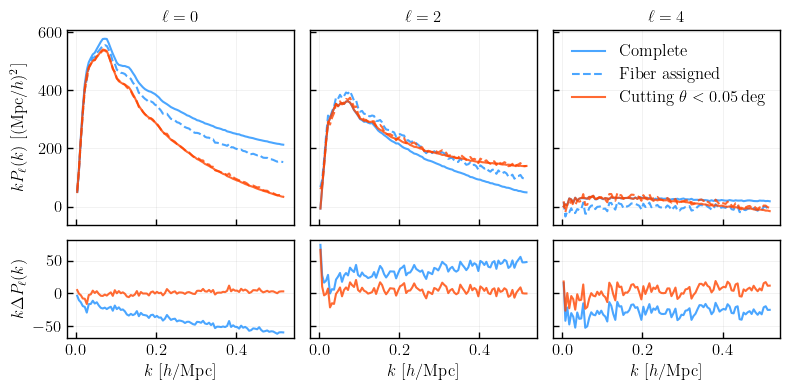

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(8, 4), sharey='row', sharex=True, gridspec_kw={'height_ratios': [4, 2]})

for c, cut in zip(['C0', 'C1'], [0., max(rpcut, thetacut)]):
    fn.set_default_config(completeness=False)
    poles = load_poles_list([fn.get_path(realization=imock, rpcut=min(cut, rpcut), thetacut=min(cut, thetacut)) for imock in imocks], rebin=5)
    fn.set_default_config(completeness=True)
    poles_complete = load_poles_list([fn.get_path(realization=imock, rpcut=min(cut, rpcut), thetacut=min(cut, thetacut)) for imock in imocks], rebin=5)
    for i, ell in enumerate(ells):
        axes[0][i].plot(poles_complete['k'][i], poles_complete['k'][i] * poles_complete['data'][i], color=c, ls='-', alpha=0.8)
        axes[0][i].plot(poles['k'][i], poles['k'][i] * poles['data'][i], color=c, ls='--', alpha=0.8)
        axes[1][i].plot(poles['k'][i], poles['k'][i] * (poles['data'][i] - poles_complete['data'][i]), color=c, alpha=0.8)

axes[0][0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$k \Delta P_{\ell}(k)$')

for i, ell in enumerate(ells):
    axes[1][i].set_xlabel(r'$k$  [$h$/Mpc]')
    axes[0][i].set_title(r'$\ell={}$'.format(ell))
    axes[0][i].plot([], [], ls='-', label='Complete', color='C0', alpha=0.8)
    axes[0][i].plot([], [], ls='--', label='Fiber assigned', color='C0', alpha=0.8)
    if rpcut:
        axes[0][i].plot([], [], ls='-', label='Cutting $r_{{\perp}} < {} \; \mathrm{{Mpc}}/h$'.format(rpcut), color='C1', alpha=0.8)
    if thetacut:
        axes[0][i].plot([], [], ls='-', label=r'Cutting $\theta < {} \deg$'.format(thetacut), color='C1', alpha=0.8)

axes[0][2].legend()
fig.align_ylabels()
plt.tight_layout(pad=0.3)
plt.savefig(os.path.join(plots_dir, version, 'power_fiberassign_{}cut{}_{}_{}_z{:.2f}-{:.2f}_{}mocks.pdf'.format('rp' if rpcut else 'theta', max(rpcut, thetacut), tracer, region, zrange[0], zrange[1], len(imocks))), dpi=200)
plt.show()

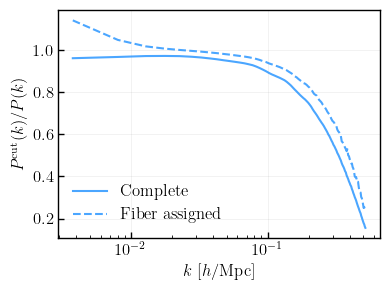

In [13]:
plt.figure(figsize=(4, 3))

# monopole only
for ls, completeness in zip(['-', '--'], [True, False]):
    fn.set_default_config(completeness=completeness)
    poles = load_poles_list([fn.get_path(realization=imock, rpcut=0, thetacut=0) for imock in imocks], rebin=5)
    poles_cut = load_poles_list([fn.get_path(realization=imock, rpcut=rpcut, thetacut=thetacut) for imock in imocks], rebin=5)
    plt.plot(poles['k'][0], (poles_cut['data'][0]/poles['data'][0]), color='C0', ls=ls, alpha=0.8)
    # legend
    plt.plot([], [], ls=ls, label='Complete' if completeness else 'Fiber assigned', color='C0', alpha=0.8)
plt.xscale('log')

plt.ylabel(r'$P^{\mathrm{cut}}(k) / P(k)$')
plt.xlabel(r'$k$  [$h$/Mpc]')
plt.legend()
plt.show()